In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn

In [2]:
from gridWorldEnvironment import GridWorld

In [3]:
# creating gridworld environment
gw = GridWorld(gamma = .9, theta = .5)

In [4]:
def state_action_value(env):
    q = dict()
    for state, action, next_state, reward in env.transitions:
        q[(state, action)] = np.random.normal()
    return q

In [5]:
def e_greedy(env, e, q, state):
    actions = env.actions
    action_values = []
    prob = []
    for action in actions:
        action_values.append(q[(state, action)])
    for i in range(len(action_values)):
        if i == np.argmax(action_values):
            prob.append(1 - e + e/len(action_values))
        else:
            prob.append(e/len(action_values))
    return actions, prob

In [6]:
def generate_e_greedy_policy(env, e, Q):
    pi = dict()
    for state in env.states:
        pi[state] = e_greedy(env, e, Q, state)
    return pi

In [7]:
def generate_random_policy(env):
    pi = dict()
    for state in env.states:
        actions = []
        prob = []
        for action in env.actions:
            actions.append(action)
            prob.append(0.25)
        pi[state] = (actions, prob)
    return pi

In [8]:
def avg_over_actions(pi, Q, state):
    actions, probs = pi[state]
    q_values = np.zeros(4)
    for s, a in Q.keys():
        if s == state:
            q_values[actions.index(a)] = Q[s,a]
    return np.dot(q_values, probs)

### A Unifying Algorithm:  Off-policy n-step Q(σ)

In [20]:
def n_step_Qσ(env, b, epsilon, alpha, n, num_iter, learn_pi = True):
    Q = state_action_value(env)
    Q_, pi_, delta, sigma, b_ , rho_ = dict(), dict(), dict(), dict(), dict(), dict()
    pi = generate_e_greedy_policy(env, epsilon, Q)
    
    for _ in range(num_iter):
        current_state = np.random.choice(env.states)
        action = np.random.choice(b[current_state][0], p = b[current_state][1])
        state_trace, action_trace, reward_trace  = [current_state], [action], [0]
        Q_[0] = Q[current_state, action]
        sigma[0]=np.random.random(1)[0]
        rho_[0]=1
        
        t, T = 0, 10000
        while True:
            if t < T:
                next_state, reward = env.state_transition(current_state, action)
                state_trace.append(next_state)
                reward_trace.append(reward)
                if next_state == 0:
                    T = t + 1
                    delta[t] = reward - Q_[t]
                else:
                    action = np.random.choice(b[next_state][0], p = b[next_state][1])
                    action_trace.append(action)
                    sigma[t+1]=np.random.random(1)[0]
                    Q_[t+1] = Q[next_state, action]
                    
                    delta[t] = reward +env.gamma*sigma[t+1]*Q_[t+1] \
                    + env.gamma *(1-sigma[t+1])* avg_over_actions(pi, Q, next_state) - Q_[t]
                    
                    pi_[t+1] = pi[next_state][1][pi[next_state][0].index(action)]
                    b_[t+1]= b[next_state][1][b[next_state][0].index(action)]
                    rho_[t+1]=pi_[t+1]/b_[t+1]
                   
            tau = t - n + 1
            if tau >= 0:
                rho = 1
                Z = 1
                G = Q_[tau]
                for i in range(tau, min([tau + n -1, T-1])):
                    G+=Z*delta[i]
                    Z=env.gamma*Z*((1-sigma[i+1])*pi_[i+1]+sigma[i+1])
                    rho*=(1-sigma[i]+sigma[i+1]*rho_[i])
                Q[state_trace[tau], action_trace[tau]] += alpha *rho* (G - Q[state_trace[tau], action_trace[tau]])
                if learn_pi:
                    pi[state_trace[tau]] = e_greedy(env, epsilon, Q, state_trace[tau])
                    
            current_state = next_state  
            
            if tau == (T-1):
                break
            t += 1
            
    return pi, Q

In [21]:
# any policy with random probabilities > 0
b = generate_random_policy(gw)

In [31]:
pi, Q = n_step_Qσ(gw, b, 0.2, 0.1, 2, 1000)

In [32]:
def show_policy(pi, env):
    temp = np.zeros(len(env.states) + 2)
    for s in env.states:
        a = pi[s][0][np.argmax(pi[s][1])]
        if a == "U":
            temp[s] = 0.25
        elif a == "D":
            temp[s] = 0.5
        elif a == "R":
            temp[s] = 0.75
        else:
            temp[s] = 1.0
            
    temp = temp.reshape(4,4)
    ax = seaborn.heatmap(temp, cmap = "prism", linecolor="#282828", cbar = False, linewidths = 0.1)
    plt.show()

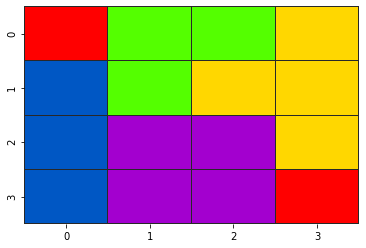

In [33]:
### RED = TERMINAL (0)
### GREEN = LEFT
### BLUE = UP
### PURPLE = RIGHT
### ORANGE = DOWN

show_policy(pi, gw)